# Rock Paper Scissor Classification

- Creates an algorithm that classifies pictures of hand as rock paper or scissor and labels them accordingly.

### Libraries

In [1]:
import tensorflow as tf
import keras
import tensorflow_datasets as tfds
import seaborn as sns
import numpy as np

from tensorflow.keras.layers import Layer


#using InceptionV3 model for transfer learning
from tensorflow.keras.applications import InceptionV3

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


### Importing Dataset

Dataset comes from tensorflow datasets

In [3]:
(rps_train, rps_valid, rps_test), info = tfds.load("rock_paper_scissors", 
                                                 data_dir='A:\\tensorflow_datasets', 
                                                 split=['train[:90%]','train[90%:100%]+test[:95%]', 'test[95%:100%]'],
                                                 shuffle_files=True,
                                                 as_supervised=True,
                                                 with_info=True)

In [4]:
print('Training dataset size:', len(rps_train))
print('Validation dataset size:', len(rps_valid))
print('Testing dataset size:', len(rps_test))

Training dataset size: 2268
Validation dataset size: 605
Testing dataset size: 19


In [5]:
#Dataset Info
info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

In [6]:
#labels
info.features['label'].names

['rock', 'paper', 'scissors']

In [7]:
#image Shape
info.features['image'].shape

(300, 300, 3)

### Preprocessing

In [8]:
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

In [9]:
#Function that normalizes images
def normalize_img(features, label):
    return tf.cast(features, tf.float32)/255.0, label

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
rps_train = rps_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
rps_train = rps_train.cache()
rps_train = rps_train.batch(BATCH_SIZE)
rps_train = rps_train.prefetch(AUTOTUNE)
rps_train = rps_train.shuffle(len(rps_train))
rps_train = rps_train.repeat(2)

rps_valid = rps_valid.map(normalize_img, num_parallel_calls=AUTOTUNE)
rps_valid = rps_valid.cache()
rps_valid = rps_valid.batch(BATCH_SIZE)
rps_valid = rps_valid.prefetch(AUTOTUNE)
rps_valid = rps_valid.shuffle(len(rps_valid))
rps_valid = rps_valid.repeat(2)

rps_test = rps_test.map(normalize_img, num_parallel_calls=AUTOTUNE)
rps_test = rps_test.cache()
rps_test = rps_test.batch(BATCH_SIZE)
rps_test = rps_test.prefetch(AUTOTUNE)
rps_test = rps_test.shuffle(len(rps_test))
rps_test = rps_test.repeat(2)

In [17]:
#Custom callback function that stops the model training upon reaching 99% validation accuracy
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if((logs.get('val_accuracy')>0.95)):
            print('\nVal Accuracy reached! Cancelling Training!')
            self.model.stop_training = True

### Modelling

In [18]:
callbacks=myCallback()

In [19]:
with strategy.scope():
    conv_base = InceptionV3(include_top=False, weights='imagenet', input_shape=(300, 300, 3))
    conv_base.trainable = False
    model = tf.keras.models.Sequential([conv_base, 
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(254, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                                        tf.keras.layers.Dropout(0.1),
                                        tf.keras.layers.Dense(3, activation='softmax')
])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

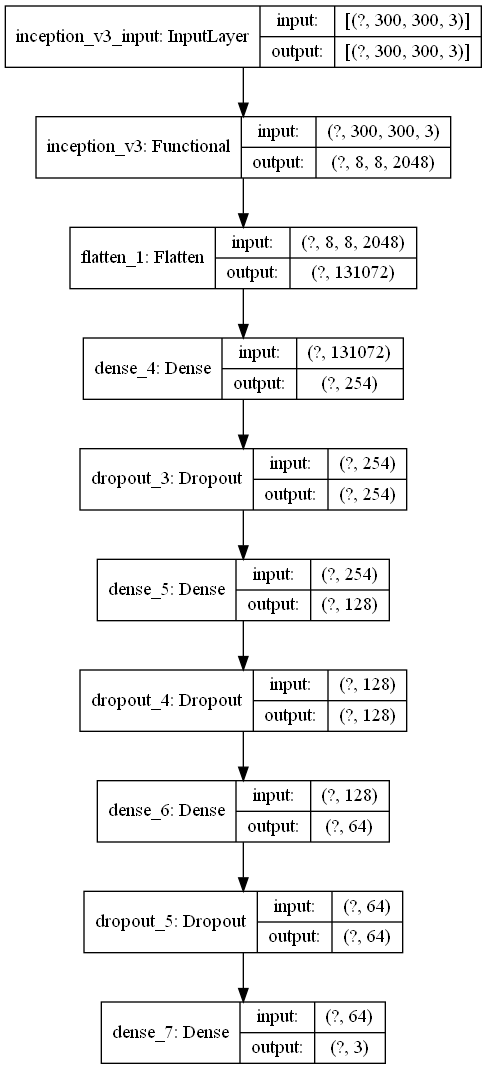

In [20]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [21]:
history = model.fit(rps_train, epochs=50, validation_data=rps_valid, callbacks=[callbacks])

Epoch 1/50
142/142 [==============================] - 51s 361ms/step - loss: 7.4434 - accuracy: 0.9253 - val_loss: 4.0373 - val_accuracy: 0.8298
Epoch 2/50
142/142 [==============================] - 45s 317ms/step - loss: 2.1177 - accuracy: 0.9727 - val_loss: 1.8716 - val_accuracy: 0.8860
Epoch 3/50
142/142 [==============================] - 15s 104ms/step - loss: 1.6701 - accuracy: 0.9597 - val_loss: 2.1132 - val_accuracy: 0.8826
Epoch 4/50
142/142 [==============================] - 14s 102ms/step - loss: 1.3520 - accuracy: 0.9711 - val_loss: 1.6180 - val_accuracy: 0.8413
Epoch 5/50
142/142 [==============================] - 15s 102ms/step - loss: 1.2895 - accuracy: 0.9497 - val_loss: 1.2797 - val_accuracy: 0.8975
Epoch 6/50
142/142 [==============================] - 15s 103ms/step - loss: 1.1530 - accuracy: 0.9356 - val_loss: 1.6569 - val_accuracy: 0.8777
Epoch 7/50
142/142 [==============================] - 15s 102ms/step - loss: 1.1640 - accuracy: 0.8918 - val_loss: 1.3313 - val_ac

In [22]:
model.evaluate(rps_test)

2/2 [==============================] - 0s 60ms/step - loss: 0.5797 - accuracy: 0.8421


[0.579696536064148, 0.8421052694320679]

In [23]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

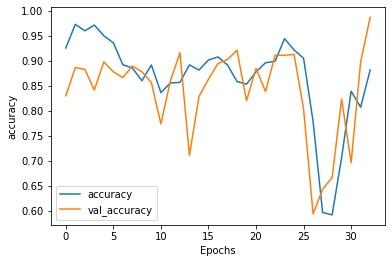

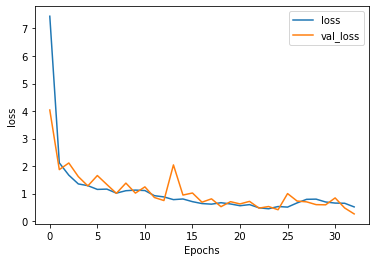

In [24]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [28]:
model.save('rps_model.h5')